<a href="https://colab.research.google.com/github/antonKornilov1/some/blob/architecture2/Lenet_mnist_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np
import time

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.49MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.72MB/s]


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

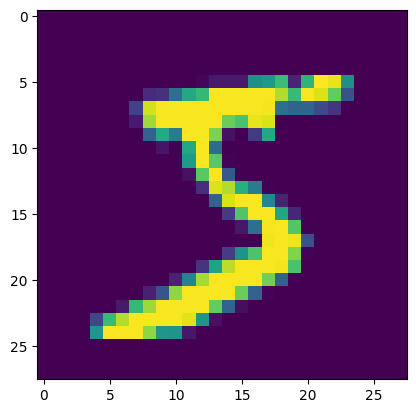

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1_1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.act1_1  = torch.nn.ReLU()

        self.conv1_2 = torch.nn.Conv2d(
            in_channels=6, out_channels=6, kernel_size=3, padding=1)
        self.act1_2  = torch.nn.ReLU()


        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = torch.nn.Conv2d(6, 16, kernel_size=3, padding=0)
        self.act2_1 = torch.nn.ReLU();

        self.conv2_2 = torch.nn.Conv2d(16, 16, kernel_size=3, padding=0)
        self.act2_2 = torch.nn.ReLU();

        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):

        x = self.act1_1(self.conv1_1(x))
        x = self.act1_2(self.conv1_2(x))
        x = self.pool1(x)

        x = self.act2_1(self.conv2_1(x))
        x = self.act2_2(self.conv2_2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

lenet5 = LeNet5()

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [12]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []
epoch_times = []


X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(25):
    start_time = time.time()
    order = np.random.permutation(len(X_train))
    epoch_train_loss = 0
    batch_count = 0

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet5.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

        epoch_train_loss += loss_value.item()
        batch_count += 1

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    avg_train_loss = epoch_train_loss / batch_count
    train_loss_history.append(avg_train_loss)

    test_preds = lenet5.forward(X_test)

    val_loss_value = loss(test_preds, y_test).data.cpu()
    test_loss_history.append(val_loss_value)

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    # print(accuracy)
    print(f"Epoch {epoch}: "
          f"Train Loss = {avg_train_loss:.4f}, "
          f"Val Loss = {val_loss_value.item():.4f}, "
          f"Accuracy = {accuracy.item():.4f}, "
          f"Time = {epoch_time:.2f}s")

Epoch 0: Train Loss = 0.1575, Val Loss = 0.0590, Accuracy = 0.9820, Time = 22.93s
Epoch 1: Train Loss = 0.0504, Val Loss = 0.0465, Accuracy = 0.9838, Time = 22.09s
Epoch 2: Train Loss = 0.0372, Val Loss = 0.0445, Accuracy = 0.9853, Time = 21.35s
Epoch 3: Train Loss = 0.0311, Val Loss = 0.0388, Accuracy = 0.9880, Time = 21.90s
Epoch 4: Train Loss = 0.0268, Val Loss = 0.0389, Accuracy = 0.9878, Time = 22.25s
Epoch 5: Train Loss = 0.0227, Val Loss = 0.0412, Accuracy = 0.9878, Time = 22.23s
Epoch 6: Train Loss = 0.0185, Val Loss = 0.0393, Accuracy = 0.9891, Time = 22.32s
Epoch 7: Train Loss = 0.0163, Val Loss = 0.0391, Accuracy = 0.9885, Time = 22.13s
Epoch 8: Train Loss = 0.0152, Val Loss = 0.0344, Accuracy = 0.9907, Time = 22.42s
Epoch 9: Train Loss = 0.0151, Val Loss = 0.0451, Accuracy = 0.9898, Time = 22.08s
Epoch 10: Train Loss = 0.0132, Val Loss = 0.0393, Accuracy = 0.9889, Time = 22.24s
Epoch 11: Train Loss = 0.0139, Val Loss = 0.0356, Accuracy = 0.9894, Time = 21.61s
Epoch 12: Trai

In [13]:
lenet5.forward(X_test)

tensor([[-19.1952,  -3.9862,  -4.9468,  ...,  20.9365, -15.5611,  -4.2203],
        [ -6.9169, -13.0129,  40.8889,  ...,  -8.8470, -25.8092, -13.9134],
        [ -6.4282,  15.9878,  -3.0859,  ...,  -0.5780,   2.1267, -10.1892],
        ...,
        [-19.0233, -11.7756, -17.7173,  ..., -10.5590,  -8.2744,  -1.3363],
        [-12.3455, -20.3288, -10.4124,  ..., -11.8902,  -3.4838, -11.0444],
        [ -2.0585,  -8.4891,  -2.1017,  ..., -14.5008,  -7.4396,  -9.8606]],
       grad_fn=<AddmmBackward0>)

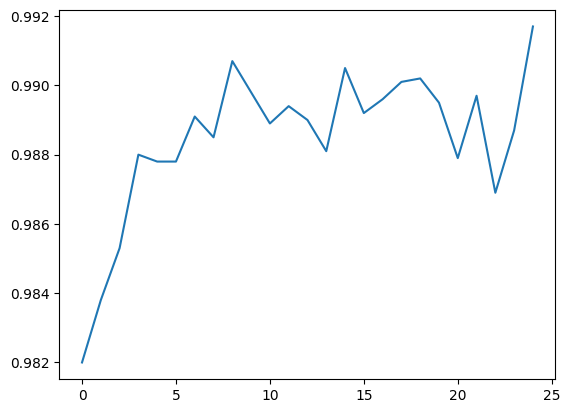

In [14]:
plt.plot(test_accuracy_history);

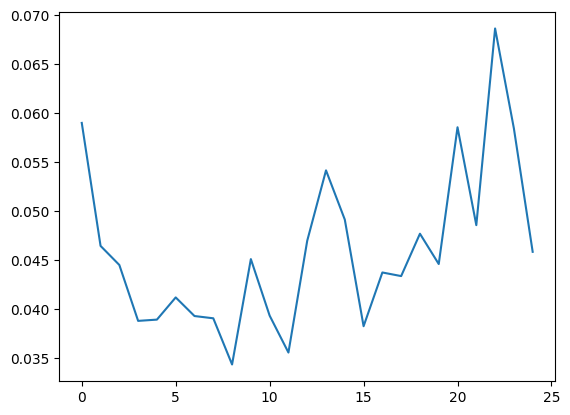

In [15]:
plt.plot(test_loss_history);

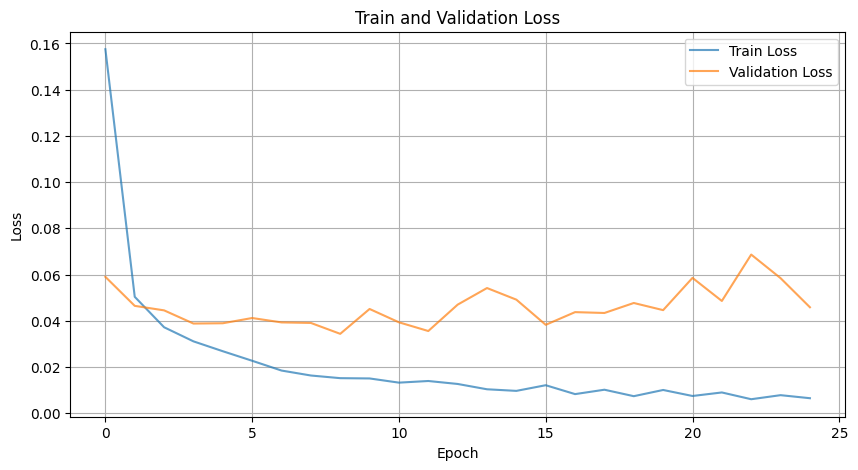

In [16]:
test_accuracy_history = [float(x) for x in test_accuracy_history]
test_loss_history = [float(x) for x in test_loss_history]

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss', alpha=0.7)
plt.plot(test_loss_history, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()